# SST2 Dataset

In [1]:
import sys
sys.path.append('../')
import torch
import numpy as np
import utils

In [2]:
from model import Model
from dataset_class import SST2Dataset
from evaluation import EvaluationClassification
import acquisition
import estimators
import metrics
import visualize
import ase

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
prompt_respond = f"""Classify the sentiment of the following sentence as "positive" or "negative". Respond with "positive" or "negative".\n"""

In [4]:
dataset_file = 'sst2'

## LLaMa2 70B

In [6]:
model_file = "llama2_70b"

In [ ]:
llama = Model(model_name="Llama-2-70b",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

In [ ]:
sst2_dataset = SST2Dataset(dataset_file)
sst2_dataset.load(llama.prompt, llama.model.tokenizer, device)

In [ ]:
llama_evaluation = EvaluationClassification(llama,
                                        sst2_dataset,
                                        device)

In [10]:
llama_evaluation.evaluation_procedure('active', batch_size=20, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [14:15<00:00,  1.71s/it]

Accuracy: 0.7680000066757202 - Loss: 0.5808222889900208


In [14]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=50, batch_size=1, save=True, version=1)

 30%|█████████████████████████████▋                                                                     | 2999/10000 [54:06<2:06:37,  1.09s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:00:23<00:00,  1.08s/it]

Accuracy: 0.9359999895095825 - Loss: 0.18283617496490479


## Llama2 7B

In [10]:
model_file = "llama2_7b"

In [ ]:
llama = Model(model_name="Llama-2-7b-8bit",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

In [ ]:
sst2_dataset = SST2Dataset(dataset_file)
sst2_dataset.load(llama.prompt, llama.model.tokenizer, device)

In [13]:
llama_evaluation = EvaluationClassification(llama,
                                            sst2_dataset,
                                            device)

In [16]:
llama_evaluation.evaluation_procedure('active', batch_size=50, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:48<00:00,  1.14s/it]

Accuracy: 0.6395999789237976 - Loss: 0.5638608932495117


In [14]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=50, batch_size=1, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [55:34<00:00,  3.00it/s]

Accuracy: 0.9334999918937683 - Loss: 0.18805083632469177


## Acquisition

In [5]:
STEP = 1
RUNS = 3_000
SIZE = 400

### LURE-based Active Testing

In [27]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

100%|██████████| 3000/3000 [30:53<00:00,  1.62it/s]    


In [ ]:
phi_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file='llama2_7b_icl50',
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
phi_acquisition.get_coverage_estimation(n_runs=100)

### Active testing with no weight (naive)

In [ ]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            estimator=estimators.iidEstimator,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

### I.I.D.

In [30]:
llama_acquisition = acquisition.iidAcquisition(step=STEP,
                                                runs=RUNS,
                                                size=SIZE,
                                                eps=1e-15,
                                                model_file="llama2_70b_icl50",
                                                dataset_file=dataset_file,
                                                loss=metrics.cross_entropy_loss)
llama_acquisition.run_estimation()

100%|██████████| 3000/3000 [06:50<00:00,  7.31it/s]


### ASE

In [43]:
ase_estimator = ase.ActiveSurrogateEstimator(model_file="llama2_70b_icl50",
                                            surrogate_file="llama2_7b_icl50",
                                            dataset_file=dataset_file,
                                            loss=metrics.cross_entropy_loss)
ase_estimator.zero_shot_estimate()

## Figures

In [6]:
visualize.setup_matplotlib()

In [7]:
true_error = utils.load_tensors(f'sst2/llama2_70b_icl50/full_set_loss').numpy()

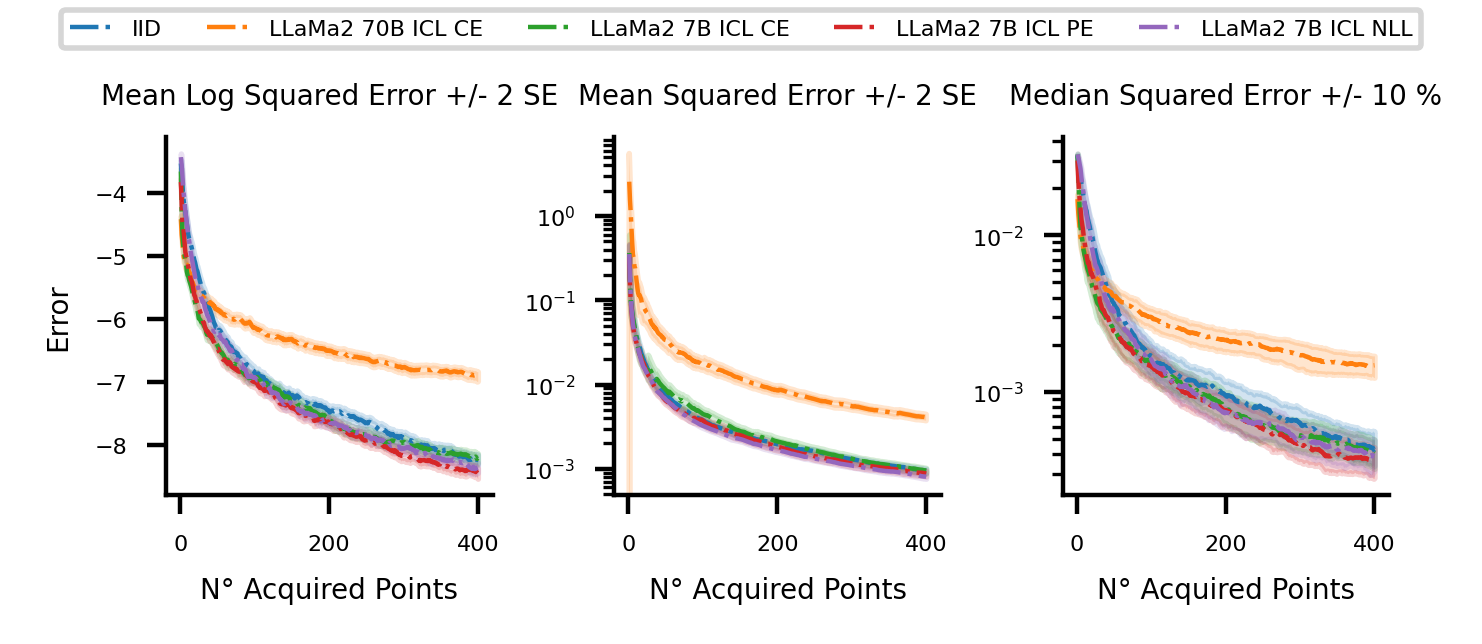

In [8]:
res_dict = {
    'IID': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_iid_loss'),
    'LLaMa2 70B ICL CE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_loss'), 
    'LLaMa2 7B ICL CE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss'), 
    'LLaMa2 7B ICL PE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_entropy'), 
    'LLaMa2 7B ICL NLL': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_nll'), 
}
visualize.plot_all_errors(res_dict, true_error, STEP, title='', savefig=(False, ''))

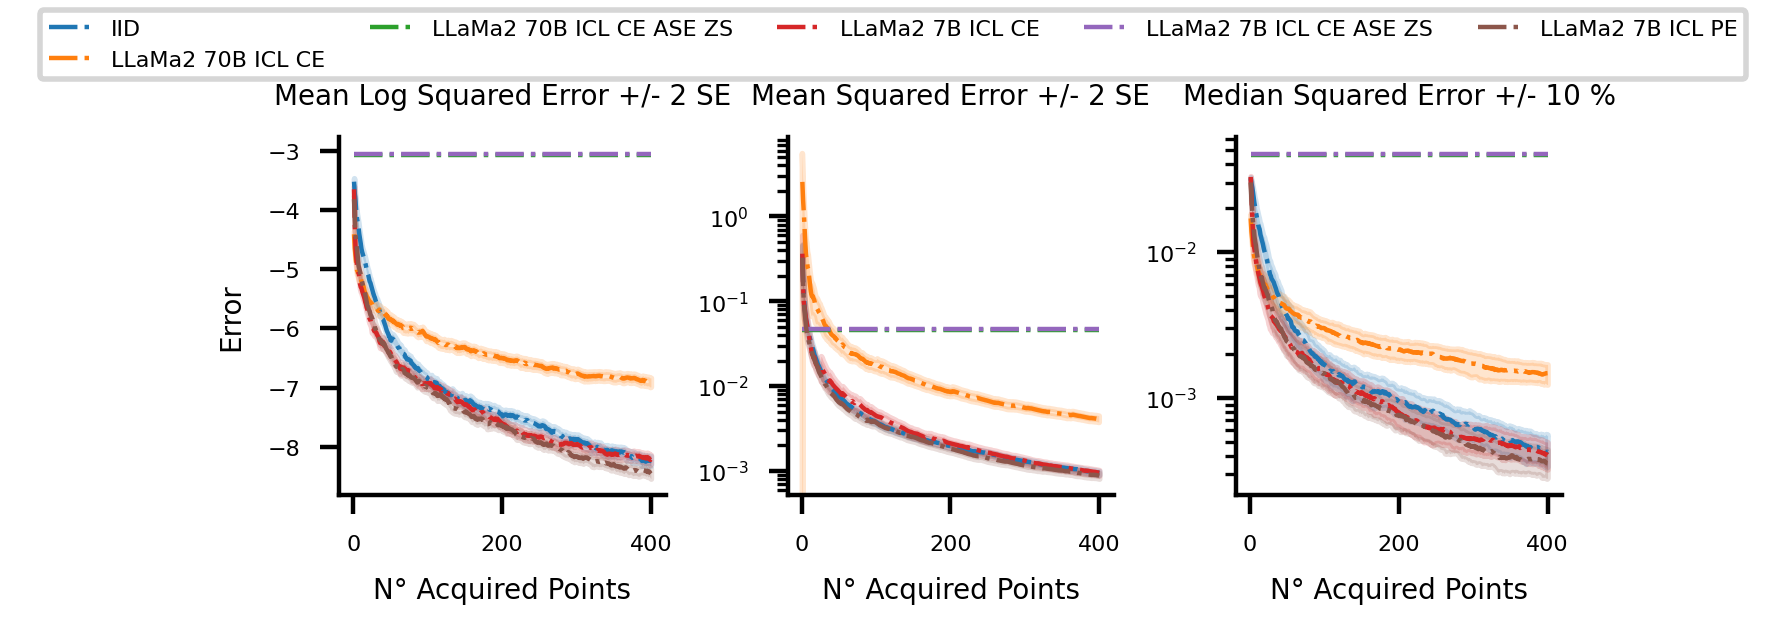

In [9]:
res_dict = {
    'IID': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_iid_loss'),
    'LLaMa2 70B ICL CE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_loss'), 
    'LLaMa2 70B ICL CE ASE ZS': np.array([utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_ase_loss_zs')]*400), 
    'LLaMa2 7B ICL CE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss'), 
    'LLaMa2 7B ICL CE ASE ZS': np.array([utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_ase_loss_zs')]*400), 
    'LLaMa2 7B ICL PE': utils.load_arrays('sst2/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_entropy'), 
}
visualize.plot_all_errors(res_dict, true_error, 1, title='', savefig=(False, ''))